# Pattern Analysis
https://web.ist.utl.pt/rmch/dash/guides/AssociationRuleMining%20in%20Python.html

Association Pattern Analysis

- What are the aisles most purchased together?
- Which aisles are most reordered together?
- Which aisles are most ordered isolately?

ARM Resources
- https://www.kaggle.com/code/datatheque/association-rules-mining-market-basket-analysis/notebook
- https://comum.rcaap.pt/bitstream/10400.26/37552/1/Tese_JoanaOliveira.pdf

# File and libraries

In [367]:
import pandas as pd
import scipy.stats as stats
from mlxtend.frequent_patterns import apriori, association_rules



- apriori method - is used to first identify the most frequent itemsets in the data.
    - How does it work?
        - It takes a dataset of transactions (or a binary dataframe where each column represents an item and each row represents a transaction).
        - It finds frequent itemsets, meaning items that appear together in at least a minimum number of transactions (defined by min_support).

- association_rules - After obtaining frequent itemsets using apriori, you can extract association rules using association_rules.

    - How does it work?
        - It uses the frequent itemsets to generate rules like:
            {A} → {B} (if a customer buys A, there is a high probability they will buy B).
        - It evaluates rule strength using metrics such as:
        -   support → how often the rule appears in the dataset.
        - confidence → how often B is bought when A is bought.
        - lift → whether A and B occur together more often than expected by chance.

***Summary***
- Use Apriori (apriori) to find groups of items frequently bought together.
- Use Association Rules (association_rules) to generate rules like “if customers buy A, they are likely to buy B.”

## DSLabs

In [368]:
%run "scripts/dslabs_functions.py"

dslabs_functions lodaded


# data functions

In [369]:
%run "scripts/data_functions.py"

data_functions lodaded


# Load

In [370]:
import pandas as pd
import numpy as np



#get file from data pre processing notebook. This file has all the column we need to start the data profiling phase
filepath = r'data/citi_bike_pre_proc.csv'

excel_mapping_filepath=r'data/citi_bike_values_encoded.xlsx'

file_tag = 'Citi Bike'



In [534]:
test_data = True
# test_data = False

# Load the data
if test_data:
    df = pd.read_csv(filepath, na_values="")

    df: DataFrame = df.sample(frac=0.3, replace = False)

else:
    # If not test_data, load the entire dataset
    df = pd.read_csv(filepath)

id_cols=['ride_id',
         'start_time', 
         'end_time',
         'start_station',
         'end_station',
         'start_station_id',
         'end_station_id',
         'start_lat',
         'start_lng', 
         'end_lat', 
         'end_lng',
         'hour',
         'wmo_weather_code',
         'snowfall_cm',
         'ride_duration_sec']
#remove also col = 'snowfall_cm' because it has only 0 values in our dataset
#remove also start_station and end_Station = they have too many unique values(around 2k) which will make the encoding process very slow

# Remove unnecessary columns
df = df.drop(columns=id_cols, axis=1)

df_enc = df.copy()  # DataFrame com as variáveis codificadas

display(df_enc.info())
display(df_enc.shape)

#alterar consoante a necessidade:
#- se quiser considerar a remoçao de outliers, alterar para "df_prep_outl"
#- se nao quiser considerar a remoçao de outliers, alterar para "df_enc"
use_df = "df_enc"  # Pode ser "df_enc" ou "df_prep_outl"


<class 'pandas.core.frame.DataFrame'>
Index: 958079 entries, 3138759 to 775109
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bike_type            958079 non-null  object 
 1   user_type            958079 non-null  object 
 2   start_borough        958079 non-null  object 
 3   end_borough          958079 non-null  object 
 4   day_of_month         958079 non-null  int64  
 5   day_of_week          958079 non-null  object 
 6   is_weekend           958079 non-null  int64  
 7   time_of_day          958079 non-null  object 
 8   ride_duration_min    958079 non-null  float64
 9   temperature_2m       958079 non-null  float64
 10  rain_mm              958079 non-null  float64
 11  cloud_cover_low_pct  958079 non-null  int64  
 12  wind_speed_10m       958079 non-null  float64
 13  wmo_weather_desc     958079 non-null  object 
 14  ride_distance_km     958079 non-null  float64
 15  ride_avg_speed  

None

(958079, 16)

In [487]:
summary = df.describe(include='all')

display(summary)

,bike_type,user_type,start_borough,end_borough,day_of_month,day_of_week,is_weekend,time_of_day,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed
count,958079,958079,958079,958079,958079.000000,958079,958079.000000,958079,958079.000000,958079.000000,958079.000000,958079.000000,958079.000000,958079,958079.000000,958079.000000
unique,2,2,5,6,NaN,7,NaN,6,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN
top,electric_bike,member,Manhattan,Manhattan,NaN,Monday,NaN,evening,NaN,NaN,NaN,NaN,NaN,Overcast,NaN,NaN
freq,626703,780806,606128,606080,NaN,171776,NaN,283771,NaN,NaN,NaN,NaN,NaN,409822,NaN,NaN
mean,NaN,NaN,NaN,NaN,16.659839,NaN,0.271027,NaN,13.032891,13.094104,0.079018,19.951576,15.423133,NaN,2.007600,10.981740
std,NaN,NaN,NaN,NaN,8.265521,NaN,0.444490,NaN,20.684371,5.272525,0.362763,34.818472,7.218025,NaN,1.752204,5.701760
min,NaN,NaN,NaN,NaN,1.000000,NaN,0.000000,NaN,1.001633,0.600000,0.000000,0.000000,0.800000,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,10.000000,NaN,0.000000,NaN,5.168900,9.000000,0.000000,0.000000,10.000000,NaN,0.839279,8.259394
50%,NaN,NaN,NaN,NaN,17.000000,NaN,0.000000,NaN,8.983150,12.500000,0.000000,0.000000,14.900000,NaN,1.489144,10.972596
75%,NaN,NaN,NaN,NaN,24.000000,NaN,1.000000,NaN,15.748867,17.100000,0.000000,20.000000,20.300000,NaN,2.613579,13.819032


In [508]:
df.columns

Index(['bike_type', 'user_type', 'start_borough', 'end_borough',
       'day_of_month', 'day_of_week', 'is_weekend', 'time_of_day',
       'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct',
       'wind_speed_10m', 'wmo_weather_desc', 'ride_distance_km',
       'ride_avg_speed'],
      dtype='object')

# Data encoding for Pattern mining 

# Encoding Detail

- Ordinal enconding:
  - bike_type
    - 0: classic
    - 1: eletric
  - user_type
    - 0: casual
    - 1: member

- Hierachical encoding: Simbolyic Variables
  - start_station
    - (don't consider for now as the encoding of these variables would be realy dificult because we have 2000 diferente stations)
  - end_station
    - (don't consider for now as the encoding of these variables would be realy dificult because we have 2000 diferente stations)
 

- Cyclical enconding: Simbolyic Variables
  - day_of_week
  - time_of_day
  - hour

- Dummyfication:
  - start_borough
  - end_borough
  - wmo_weather_desc 


- Numeric Values that don't need encoding
  - hour
  - day_of_month
  - is_weekend
  - ride_duration_min
  - temperature_2m
  - rain_mm
  - wmo_weather_code ?????
  - cloud_cover_low_pct
  - wind_speed_10m
  - ride_distance_km
  - ride_avg_speed

Note: week_of_month and day in our case are ordinal variables, and not cyclical, because our dataset only has data for 1 month, nov/19, which means that these two variables don't repeat over time in our dataset.

## Ordinal enconding





In [273]:
from pandas import Series, DataFrame, to_numeric, to_datetime

def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    
    for c in df.columns:
        if 2 == nr_values[c]:  # Colunas com exatamente 2 valores únicos
            variable_types["binary"].append(c)
        else:
            if df[c].dtype == 'datetime64[ns, UTC]':  # Verifica se a coluna já é datetime
                variable_types["date"].append(c)
            else:
                try:
                    df[c] = to_numeric(df[c], errors="raise")
                    variable_types["numeric"].append(c)
                except ValueError:
                    try:
                        df[c] = to_datetime(df[c], errors="raise")
                        variable_types["date"].append(c)
                    except ValueError:
                        variable_types["symbolic"].append(c)

    return variable_types

# Uso da função
variable_types: dict[str, list] = get_variable_types(df)
print(variable_types)

{'numeric': ['day_of_month', 'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'ride_distance_km', 'ride_avg_speed'], 'binary': ['bike_type', 'user_type', 'is_weekend'], 'date': [], 'symbolic': ['start_borough', 'end_borough', 'day_of_week', 'time_of_day', 'wmo_weather_desc']}


##### bulk Symbolic mapping through Excel

    - Simbolyc
        -...

    - Binary
        - is_weekend
        - bike_type
            - 0: classic
            - 1: eltric
        - user_type
            - 0: classic
            - 1: member

In [274]:


# Generalized function to encode any column based on a mapping dictionary
def encode_column_with_mapping(df, column, mapping_dict, default_value=np.nan):
    """
    Encode a column based on a mapping dictionary.
    
    Args:
    df (pd.DataFrame): The DataFrame containing the column to encode.
    column (str): The column name to encode.
    mapping_dict (dict): Dictionary where keys are the original values and values are the encodings.
    default_value: Value to assign if the key is not found in the mapping dict (default is NaN).
    
    Returns:
    pd.Series: Encoded column.
    """
    return df[column].map(mapping_dict).fillna(default_value)



def sheet_to_dict(excel_file, sheet_name):
    """
    Converts a sheet in an Excel file to a dictionary with the first column as the key and the second as the value.
    
    Args:
    excel_file (str): Path to the Excel file.
    sheet_name (str): Name of the sheet to convert.
    
    Returns:
    dict: A dictionary with keys from the first column and values from the second column.
    """
    # Read the sheet into a DataFrame
    df = pd.read_excel(excel_file, sheet_name=sheet_name)
    
    # Ensure that there are at least two columns
    if df.shape[1] < 2:
        raise ValueError(f"The sheet '{sheet_name}' does not have at least two columns.")
    
    # Create a dictionary from the first and second columns
    mapping_dict = dict(zip(df.iloc[:, 0], df.iloc[:, 1]))
    
    return mapping_dict



In [275]:
excel_file = pd.ExcelFile(excel_mapping_filepath)
sheet_names = excel_file.sheet_names  # List of all sheet names

# Iterate over each sheet and map the corresponding column
for sheet in sheet_names:
    # Assuming the sheet names match the column names in data_enc
    if sheet in df_enc.columns:
        # Load the sheet as a dictionary
        category_mapping = sheet_to_dict(excel_mapping_filepath, sheet)
        
        # Encode the corresponding column in data_enc using the mapping
        df_enc[sheet] = encode_column_with_mapping(df_enc, sheet, category_mapping)
        print(f'{sheet} column encoded')

    else:
        print(f"Warning: No matching column found in data_enc for sheet '{sheet}'")




bike_type column encoded
user_type column encoded


In [276]:
df_enc.head()

,bike_type,user_type,start_borough,end_borough,day_of_month,day_of_week,is_weekend,time_of_day,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed
1558315,0,1,Manhattan,Manhattan,27,Saturday,1,afternoon,9.775733,12.1,0.0,2,24.4,Overcast,1.445447,8.871646
2987324,0,1,Manhattan,Manhattan,10,Wednesday,0,late morning,13.026767,13.6,0.0,0,14.3,Overcast,2.847784,13.116613
971054,1,1,Manhattan,Brooklyn,15,Monday,0,lunch time,23.398117,24.1,0.0,0,20.4,Partly cloudy,5.701519,14.620457
1699523,1,1,Brooklyn,Brooklyn,14,Sunday,1,lunch time,2.037267,18.3,0.8,0,18.2,Drizzle: Moderate,0.507084,14.934233
753843,1,0,Queens,Queens,1,Monday,0,night,63.705017,5.3,0.0,0,8.9,Overcast,0.288019,0.271268


In [277]:
display(df_enc['bike_type'].value_counts())
display(df_enc['user_type'].value_counts())


bike_type
1    208863
0    110497
Name: count, dtype: int64

user_type
1    260341
0     59019
Name: count, dtype: int64

In [278]:
for v in variable_types["symbolic"]:
    print(v, df_enc[v].unique())

start_borough ['Manhattan' 'Brooklyn' 'Queens' 'Bronx' 'Staten Island' 'Jersey City']
end_borough ['Manhattan' 'Brooklyn' 'Queens' 'Bronx' 'Jersey City' 'Staten Island']
day_of_week ['Saturday' 'Wednesday' 'Monday' 'Sunday' 'Tuesday' 'Friday' 'Thursday']
time_of_day ['afternoon' 'late morning' 'lunch time' 'night' 'early morning' 'evening']
wmo_weather_desc ['Overcast' 'Partly cloudy' 'Drizzle: Moderate' 'Clear sky' 'Mainly clear'
 'Drizzle: Light' 'Rain: Moderate' 'Rain: Slight' 'Drizzle: Dense']


## Dummyifcation enconding
- Apply dummyification method to the following variables:
    - start_borough
    - end_borough
    - wmo_weather_desc
    - day_of_week
    - time_of_day
    - user_type
    - bike_type
    - is_weekend


In [535]:
# Apply one-hot encoding to the symbolic variables
df_enc = pd.get_dummies(df_enc, columns=[
    "bike_type",
    "user_type",
    "is_weekend",
    "start_borough",
     "end_borough", 
     "wmo_weather_desc",
     'day_of_week',
     'time_of_day'], dtype=int)


#dropping new columns created with dummyification because we already have is_weekend
df_enc = df_enc.drop(columns=['day_of_week_Sunday', 'day_of_week_Saturday'], axis=1)
display(df_enc.head())

,day_of_month,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed,bike_type_classic_bike,bike_type_electric_bike,user_type_casual,user_type_member,is_weekend_0,is_weekend_1,start_borough_Bronx,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,start_borough_Staten Island,end_borough_Bronx,end_borough_Brooklyn,end_borough_Jersey City,end_borough_Manhattan,end_borough_Queens,end_borough_Staten Island,wmo_weather_desc_Clear sky,wmo_weather_desc_Drizzle: Dense,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Drizzle: Moderate,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy,wmo_weather_desc_Rain: Moderate,wmo_weather_desc_Rain: Slight,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_early morning,time_of_day_evening,time_of_day_late morning,time_of_day_lunch time,time_of_day_night
3138759,27,20.574383,9.7,0.0,2,13.0,3.436230,10.020898,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3173276,11,1.325617,15.0,0.2,10,21.4,0.277694,12.568955,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
977436,12,19.635883,17.8,0.4,100,24.0,1.232500,3.766064,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3122612,10,8.809500,10.9,0.0,5,6.4,1.714013,11.673849,0,1,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1353311,18,6.654217,7.6,0.0,7,12.6,1.194919,10.774391,0,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


In [536]:
df_enc.shape

(958079, 45)

In [537]:
df_enc.columns

Index(['day_of_month', 'ride_duration_min', 'temperature_2m', 'rain_mm',
       'cloud_cover_low_pct', 'wind_speed_10m', 'ride_distance_km',
       'ride_avg_speed', 'bike_type_classic_bike', 'bike_type_electric_bike',
       'user_type_casual', 'user_type_member', 'is_weekend_0', 'is_weekend_1',
       'start_borough_Bronx', 'start_borough_Brooklyn',
       'start_borough_Manhattan', 'start_borough_Queens',
       'start_borough_Staten Island', 'end_borough_Bronx',
       'end_borough_Brooklyn', 'end_borough_Jersey City',
       'end_borough_Manhattan', 'end_borough_Queens',
       'end_borough_Staten Island', 'wmo_weather_desc_Clear sky',
       'wmo_weather_desc_Drizzle: Dense', 'wmo_weather_desc_Drizzle: Light',
       'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear',
       'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy',
       'wmo_weather_desc_Rain: Moderate', 'wmo_weather_desc_Rain: Slight',
       'day_of_week_Friday', 'day_of_week_Monday', 

# Data Preparation for Pattern mining 

## Drop Outliers

- using nr_stdev=3

In [539]:
from pandas import DataFrame, Series

# Usar a função get_variable_types() para obter as variáveis numéricas
variable_types: dict[str, list] = get_variable_types(df)
numeric: list[str] = variable_types["numeric"]


def apply_strategy_2(df: DataFrame, summary5: DataFrame, nr_stdev: float = 2) -> DataFrame:
    df_copy = df.copy()

    # Definindo as variáveis contínuas específicas que desejas monitorar


    # Filtrar apenas as variáveis contínuas que existem no DataFrame
    numeric_vars = [var for var in numeric if var in df_copy.columns]

    if numeric_vars:
        print(f"Data before dropping outliers with nr_stdev={nr_stdev}:", df_copy.shape)
        
        # Armazenar informações sobre os outliers
        outlier_info = {}

        for var in numeric_vars:
            # Calcular os limites de outlier para a variável usando o número de desvios padrão
            mean = summary5[var]['mean']
            std = summary5[var]['std']
            
            top = mean + nr_stdev * std
            bottom = mean - nr_stdev * std
            
            # Identificar os outliers
            outliers: Series = df_copy[(df_copy[var] > top) | (df_copy[var] < bottom)]
            
            # Se houver outliers, armazenar as informações
            if not outliers.empty:
                outlier_info[var] = {
                    'outlier_indices': outliers.index.tolist(),
                    'outlier_count': outliers.shape[0],
                    'outlier_values': outliers[var].tolist()
                }

                # Remover outliers
                df_copy.drop(outliers.index, axis=0, inplace=True)
        
        print(f"Data after dropping outliers with nr_stdev={nr_stdev}:", df_copy.shape)

        # Imprimir informações sobre os outliers removidos apenas para as variáveis com outliers
        if outlier_info:
            for var, info in outlier_info.items():
                print(f"Variable '{var}':")
                print(f"  Number of outliers removed: {info['outlier_count']}")
                print(f"  Indices of outliers: {info['outlier_indices']}")
                print(f"  Values of outliers: {info['outlier_values']}")
                print()  # Linha em branco para melhor legibilidade
        else:
            print("No outliers were removed.")
    else:
        print("There are no numeric variables")

    return df_copy

# Usar a função
summary5 = df.describe()  # Calcular o resumo estatístico apenas para as variáveis de interesse
nr_stdev = 3  # Exemplo, mas pode ser alterado para 3 ou outro valor

df_prep_outl = apply_strategy_2(df_enc, summary5, nr_stdev)


Data before dropping outliers with nr_stdev=3: (958079, 45)
Data after dropping outliers with nr_stdev=3: (913617, 45)
Variable 'ride_duration_min':
  Number of outliers removed: 6319
  Indices of outliers: [2787653, 99348, 2097133, 2952362, 85724, 459138, 1755389, 653247, 921502, 1997564, 2174984, 970083, 1830721, 102833, 108280, 2538549, 2620318, 2942133, 1107682, 838917, 2157280, 2299738, 485061, 480788, 2333151, 3023393, 2576820, 1900661, 849069, 2638728, 2287667, 2189072, 703765, 2340140, 309580, 3157396, 558181, 562740, 2762077, 1911808, 542976, 1797177, 2690838, 3085643, 698258, 3121544, 1403741, 499181, 1487049, 1122612, 3132600, 2995036, 1906299, 627432, 1214374, 1760415, 324029, 1989402, 639875, 1782766, 1013942, 404439, 3040981, 992760, 156928, 940031, 925856, 1550434, 1944666, 2301773, 2380483, 2577560, 1590426, 1214381, 1308734, 92762, 703122, 2524263, 3157967, 1015088, 3081700, 651982, 263434, 2980511, 2654954, 2803368, 2219804, 696093, 235197, 1257380, 3161752, 1825345, 

In [540]:
df_prep_outl.shape

(913617, 45)

In [541]:
df_prep_outl.columns

Index(['day_of_month', 'ride_duration_min', 'temperature_2m', 'rain_mm',
       'cloud_cover_low_pct', 'wind_speed_10m', 'ride_distance_km',
       'ride_avg_speed', 'bike_type_classic_bike', 'bike_type_electric_bike',
       'user_type_casual', 'user_type_member', 'is_weekend_0', 'is_weekend_1',
       'start_borough_Bronx', 'start_borough_Brooklyn',
       'start_borough_Manhattan', 'start_borough_Queens',
       'start_borough_Staten Island', 'end_borough_Bronx',
       'end_borough_Brooklyn', 'end_borough_Jersey City',
       'end_borough_Manhattan', 'end_borough_Queens',
       'end_borough_Staten Island', 'wmo_weather_desc_Clear sky',
       'wmo_weather_desc_Drizzle: Dense', 'wmo_weather_desc_Drizzle: Light',
       'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear',
       'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy',
       'wmo_weather_desc_Rain: Moderate', 'wmo_weather_desc_Rain: Slight',
       'day_of_week_Friday', 'day_of_week_Monday', 

In [542]:
display(df.shape) # original df
display(df_enc.shape) # df after enconding
display(df_prep_outl.shape) # df after enconding and data prep outlier removal


(958079, 16)

(958079, 45)

(913617, 45)

In [543]:
display(df_prep_outl.head())

,day_of_month,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed,bike_type_classic_bike,bike_type_electric_bike,user_type_casual,user_type_member,is_weekend_0,is_weekend_1,start_borough_Bronx,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,start_borough_Staten Island,end_borough_Bronx,end_borough_Brooklyn,end_borough_Jersey City,end_borough_Manhattan,end_borough_Queens,end_borough_Staten Island,wmo_weather_desc_Clear sky,wmo_weather_desc_Drizzle: Dense,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Drizzle: Moderate,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy,wmo_weather_desc_Rain: Moderate,wmo_weather_desc_Rain: Slight,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_early morning,time_of_day_evening,time_of_day_late morning,time_of_day_lunch time,time_of_day_night
3138759,27,20.574383,9.7,0.0,2,13.0,3.436230,10.020898,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3173276,11,1.325617,15.0,0.2,10,21.4,0.277694,12.568955,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
977436,12,19.635883,17.8,0.4,100,24.0,1.232500,3.766064,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3122612,10,8.809500,10.9,0.0,5,6.4,1.714013,11.673849,0,1,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1353311,18,6.654217,7.6,0.0,7,12.6,1.194919,10.774391,0,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


## Feature Selection

### Feat 2 - Variance Threshold (Remove Low-Variance Features)


In [544]:
display(df.shape) # original df
display(df_enc.shape) # df after enconding
display(df_prep_outl.shape) # df after enconding and data prep outlier removal

(958079, 16)

(958079, 45)

(913617, 45)

In [563]:
# Supondo que 'use_df' seja uma string que indica qual DataFrame usar
use_df = "df_enc"  # Ou "df_prep_outl", dependendo da escolha

# Escolher o DataFrame a ser utilizado com base na variável 'use_df'
if use_df == "df_enc":
    df_to_use = df_enc
elif use_df == "df_prep_outl":
    df_to_use = df_prep_outl
else:
    raise ValueError(f"Invalid DataFrame choice: {use_df}. Choose either 'df_enc' or 'df_prep_outl'.")

# Exibir qual DataFrame foi escolhido
print(f"We will use the dataset {use_df} dataset, which means that we are {'not ' if use_df == 'df_enc' else ''}considering the removal of outliers.")
print(f"Shape of dataset: {df_to_use.shape}")


We will use the dataset df_enc dataset, which means that we are not considering the removal of outliers.
Shape of dataset: (958079, 45)


In [564]:
from sklearn.feature_selection import VarianceThreshold

# Remove features with very low variance
selector = VarianceThreshold(threshold=0.01)  # Ajuste o threshold conforme necessário
X_reduced = selector.fit_transform(use_df)

# Get selected features
selected_features = use_df.columns[selector.get_support()]
print(selected_features)


ValueError: could not convert string to float: 'df_enc'

In [565]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold


# Print initial features
print("Initial features:\n", use_df.columns.tolist())

# Compute variance for each feature
feature_variance = use_df.var()
print("\nFeature Variance:\n", feature_variance)

# Define threshold (adjust based on the dataset)
threshold = 0.01
selector = VarianceThreshold(threshold=threshold)

# Fit and transform the dataset
X_reduced = selector.fit_transform(use_df)

# Get selected features
initial_features = list(set(use_df.columns))
removed_features = list(set(use_df.columns) - set(selected_features))
selected_features = use_df.columns[selector.get_support()]


# Print results
print("Initial Features df_prep:\n", initial_features)
print("\nRemoved Features (low variance < {:.3f}):\n".format(threshold), removed_features)
print("\nFinal Features list:\n", selected_features.tolist())


AttributeError: 'str' object has no attribute 'columns'

In [548]:
selected_features

Index(['day_of_month', 'ride_duration_min', 'temperature_2m', 'rain_mm',
       'cloud_cover_low_pct', 'wind_speed_10m', 'ride_distance_km',
       'ride_avg_speed', 'bike_type_classic_bike', 'bike_type_electric_bike',
       'user_type_casual', 'user_type_member', 'is_weekend_0', 'is_weekend_1',
       'start_borough_Bronx', 'start_borough_Brooklyn',
       'start_borough_Manhattan', 'start_borough_Queens', 'end_borough_Bronx',
       'end_borough_Brooklyn', 'end_borough_Manhattan', 'end_borough_Queens',
       'wmo_weather_desc_Clear sky', 'wmo_weather_desc_Drizzle: Light',
       'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear',
       'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy',
       'wmo_weather_desc_Rain: Slight', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'time_of_day_afternoon',
       'time_of_day_early morning', 'time_of_day_evening',
       'time_of

In [549]:
display(use_df.shape)
display(df_enc.shape)

(958079, 45)

(958079, 45)

In [550]:
df_prep_feat_var = use_df[selected_features]

In [551]:
display(df_enc.shape) # df after enconding
display(df_prep_outl.shape) # df after enconding and data prep outlier removal
display(use_df.shape) # df after enconding and data prep outlier removal
display(df_prep_feat_var.shape) 

(958079, 45)

(913617, 45)

(958079, 45)

(958079, 40)

### Feat 3 - Drop Redundant Variables
    - Correlation interpretation - values between [-1,1]:
        - 0.9 and above: Very strong correlation (typically, > 0.9 is considered almost perfect).
        - 0.7 to 0.9: Strong correlation.
        - 0.3 to 0.7: Moderate correlation.
        - 0.1 to 0.3: Weak correlation.
        - 0 to 0.1: No significant correlation.       

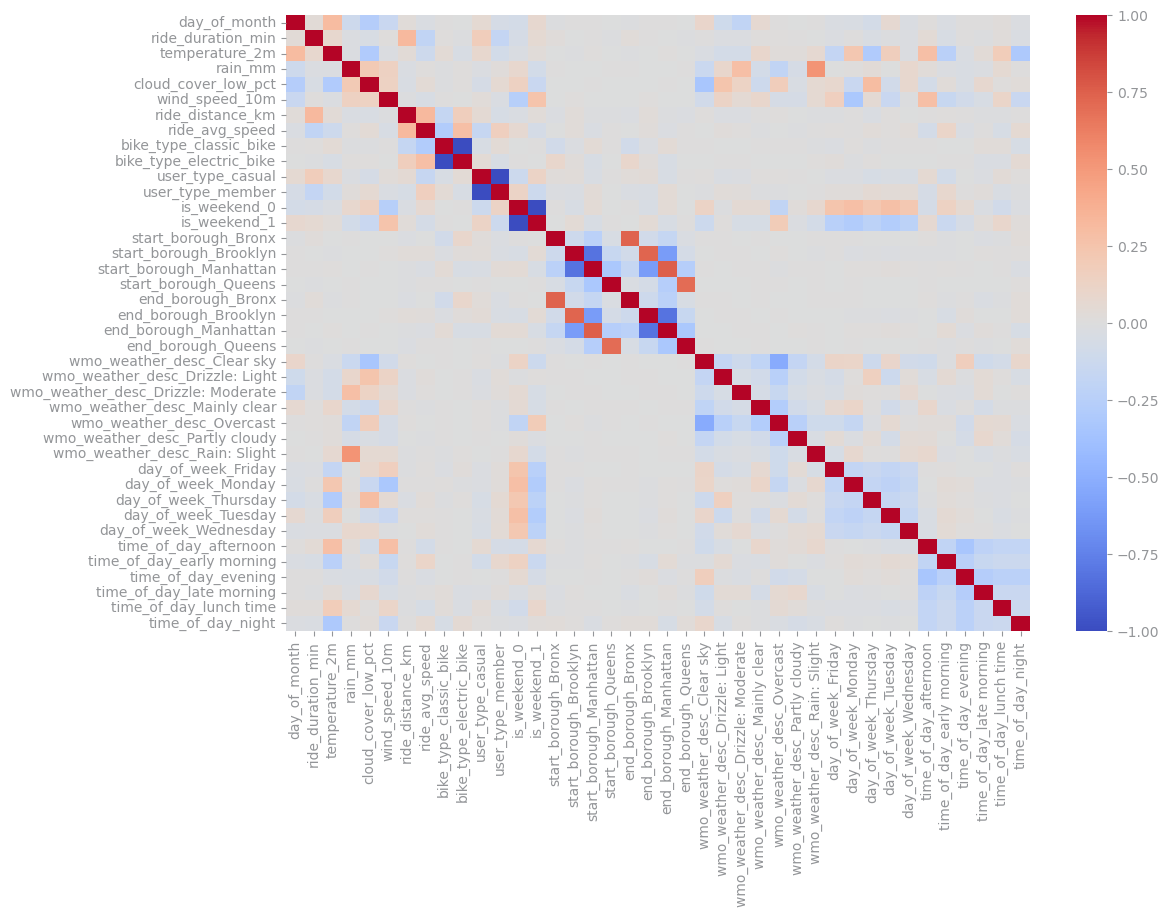

In [566]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df_prep_feat_var.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.show()

In [569]:
import numpy as np

# Calculate correlation matrix
corr_matrix = df_prep_feat_var.corr()

# Identify pairs of highly correlated features (correlation > 0.8)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Initialize an empty list to store the pairs of highly correlated features
redundant_pairs = []

# Loop through each column to find pairs with correlation > 0.8
for column in upper_tri.columns:
    for row in upper_tri.index:
        if upper_tri.loc[row, column] > 0.8:
            redundant_pairs.append((row, column, upper_tri.loc[row, column]))

# Print initial features count
print(f"Initial number of features: {len(df_prep_feat_var.columns)}")

# Print redundant pairs
print(f"Redundant pairs (correlation > 0.8):")
for pair in redundant_pairs:
    print(f"{pair[0]} and {pair[1]}: Correlation = {pair[2]}")

# Identify the features to drop based on redundancy
to_drop = [pair[1] for pair in redundant_pairs]

# Print features that will be dropped
print(f"Number of features dropped: {len(to_drop)}")
print(f"Features dropped: {to_drop}")

# Drop the correlated features
df_prep_final = df_prep_feat_var.drop(columns=to_drop)

# Print remaining features count
print(f"Remaining features: {len(df_prep_final.columns)}")
print(f"Remaining features: {df_prep_final.columns.tolist()}")


Initial number of features: 40
Redundant pairs (correlation > 0.8):
Number of features dropped: 0
Features dropped: []
Remaining features: 40
Remaining features: ['day_of_month', 'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'ride_distance_km', 'ride_avg_speed', 'bike_type_classic_bike', 'bike_type_electric_bike', 'user_type_casual', 'user_type_member', 'is_weekend_0', 'is_weekend_1', 'start_borough_Bronx', 'start_borough_Brooklyn', 'start_borough_Manhattan', 'start_borough_Queens', 'end_borough_Bronx', 'end_borough_Brooklyn', 'end_borough_Manhattan', 'end_borough_Queens', 'wmo_weather_desc_Clear sky', 'wmo_weather_desc_Drizzle: Light', 'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear', 'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy', 'wmo_weather_desc_Rain: Slight', 'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday', 'time_of_day_afternoon', 't

In [570]:
display(df.shape) # original df
display(df_enc.shape) # df after enconding
display(df_prep_outl.shape) # df after enconding and data prep outlier removal
display(df_prep_feat_var.shape) 
display(df_prep_final.shape) 

(958079, 16)

(958079, 45)

(913617, 45)

(958079, 40)

(958079, 40)

## Discritization of the numerical variable

In [627]:
df_discrit = df_prep_final.copy()

In [605]:
df_discrit.dtypes

day_of_month                            int64
ride_duration_min                     float64
temperature_2m                        float64
rain_mm                               float64
cloud_cover_low_pct                     int64
wind_speed_10m                        float64
ride_distance_km                      float64
ride_avg_speed                        float64
bike_type_classic_bike                  int64
bike_type_electric_bike                 int64
user_type_casual                        int64
user_type_member                        int64
is_weekend_0                            int64
is_weekend_1                            int64
start_borough_Bronx                     int64
start_borough_Brooklyn                  int64
start_borough_Manhattan                 int64
start_borough_Queens                    int64
end_borough_Bronx                       int64
end_borough_Brooklyn                    int64
end_borough_Manhattan                   int64
end_borough_Queens                

### Apply cut to discretize the numeric variables that follows a normal distribution
    - On this method we don't need to define the limits for each bin, cut will define them and distribute the values by the bins with the same lenght

In [602]:
df_discrit.head()
display(df_discrit.shape)

(958079, 40)

In [603]:

#don't consider the binary variables, becasue these ones are already encoded (0 or 1)

binary_var = [col for col in df_discrit.columns if df_discrit[col].nunique() ==2]

#also not considering bellow columns for qui-cut discretization, because the ydon't follow a normal distribution
except_cols = [
    'temperature_2m',
    'wind_speed_10m',
    'cloud_cover_low_pct',
    'day_of_month']

# List of columns to apply the qcut transformation
columns_to_bin = df_discrit.drop(columns=binary_var + except_cols, axis=1).columns


# Loop through the columns and apply cut with specific labels
for v in columns_to_bin:
    if v == 'ride_duration_min':
        df_discrit[v], bins_ride_duration = pd.cut(df_discrit[v], 3, labels=['short', 'medium', 'long'], retbins=True)
        print(f"Limits for {v}: {bins_ride_duration}")
    elif v == 'ride_distance_km':
        df_discrit[v], bins_ride_distance = pd.cut(df_discrit[v], 3, labels=['short', 'medium', 'long'], retbins=True)
        print(f"Limits for {v}: {bins_ride_distance}")
    elif v == 'ride_avg_speed':
        df_discrit[v], bins_ride_avg_speed = pd.cut(df_discrit[v], 3, labels=['slow', 'medium', 'fast'], retbins=True)
        print(f"Limits for {v}: {bins_ride_avg_speed}")

# Check the results
display(df_discrit[['ride_duration_min', 'ride_distance_km', 'ride_avg_speed']].value_counts())
display(df_discrit[['ride_duration_min']].value_counts())
display(df_discrit[['ride_distance_km']].value_counts())
display(df_discrit[['ride_avg_speed']].value_counts())


Limits for ride_duration_min: [-4.69140617e-01  4.91566089e+02  9.82129628e+02  1.47269317e+03]
Limits for ride_distance_km: [-0.02522993  8.40997648 16.81995295 25.22992943]
Limits for ride_avg_speed: [ -0.77765012 259.2167082  518.4334164  777.6501246 ]


ride_duration_min  ride_distance_km  ride_avg_speed
short              short             slow              948233
                   medium            slow                9480
medium             short             slow                 122
short              long              slow                 115
long               short             slow                  95
short              medium            medium                20
medium             medium            slow                   6
short              short             medium                 5
                   medium            fast                   1
                   long              medium                 1
long               medium            slow                   1
Name: count, dtype: int64

ride_duration_min
short                957855
medium                  128
long                     96
Name: count, dtype: int64

ride_distance_km
short               948455
medium                9508
long                   116
Name: count, dtype: int64

ride_avg_speed
slow              958052
medium                26
fast                   1
Name: count, dtype: int64

In [575]:
display(df_discrit.head())

,day_of_month,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed,bike_type_classic_bike,bike_type_electric_bike,user_type_casual,user_type_member,is_weekend_0,is_weekend_1,start_borough_Bronx,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,end_borough_Bronx,end_borough_Brooklyn,end_borough_Manhattan,end_borough_Queens,wmo_weather_desc_Clear sky,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Drizzle: Moderate,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy,wmo_weather_desc_Rain: Slight,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_early morning,time_of_day_evening,time_of_day_late morning,time_of_day_lunch time,time_of_day_night
3138759,27,short,9.7,0.0,2,13.0,short,slow,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3173276,11,short,15.0,0.2,10,21.4,short,slow,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
977436,12,short,17.8,0.4,100,24.0,short,slow,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3122612,10,short,10.9,0.0,5,6.4,short,slow,0,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
1353311,18,short,7.6,0.0,7,12.6,short,slow,0,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


### Testing bin limits for cols ride_duration_min, ride_distance_km, ride_avg_speed

In [580]:
df_enc[df_enc['ride_distance_km'] < 3]['ride_distance_km'].unique()

array([0.27769361, 1.23249976, 1.71401286, ..., 0.58865537, 1.18194062,
       0.91874754])

In [606]:
import pandas as pd

# Função para binning e contagem de ocorrências
def bin_and_count(df, column, bins, labels):
    df_copy = df.copy()  # Evitar modificar o DataFrame original
    # Criar a nova coluna com os bins
    df_copy[f'{column}_bin'] = pd.cut(df_copy[column], bins=bins, labels=labels, right=False)
    # Contar o número de ocorrências em cada bin
    bin_counts = df_copy[f'{column}_bin'].value_counts().sort_index()
    return bin_counts

# Definir os intervalos (bins) e labels para cada coluna
distance_bins = [0, 2, 5, 10, 15, 20, 25, 30, float('inf')]
distance_labels = ['0-2 km', '2-5 km', '5-10 km', '10-15 km', '15-20 km', '20-25 km', '25-30 km', '30+ km']

duration_bins = [0, 10, 20, 30, 40, 50, float('inf')]
duration_labels = ['0-10 min', '10-20 min', '20-30 min', '30-40 min', '40-50 min', '50+ min']

speed_bins = [0, 5, 10, 15, 20, 25, float('inf')]
speed_labels = ['0-5 km/h', '5-10 km/h', '10-15 km/h', '15-20 km/h', '20-25 km/h', '25+ km/h']

# Analisar as distâncias menores que 3 km
unique_distances = df_enc[df_enc['ride_distance_km'] < 3]['ride_distance_km'].unique()
print(f"Rows with distance < 3 km: {len(unique_distances)}")
print(f"All rows: {len(df_enc)}")

# Contar as ocorrências nos bins
distance_counts = bin_and_count(df_enc, 'ride_distance_km', distance_bins, distance_labels)
duration_counts = bin_and_count(df_enc, 'ride_duration_min', duration_bins, duration_labels)
speed_counts = bin_and_count(df_enc, 'ride_avg_speed', speed_bins, speed_labels)

# Exibir os resultados
print("\nCounts for ride distance bins:")
print(distance_counts)

print("\nCounts for ride duration bins:")
print(duration_counts)

print("\nCounts for ride average speed bins:")
print(speed_counts)



Rows with distance < 3 km: 535149
All rows: 958079

Counts for ride distance bins:
ride_distance_km_bin
0-2 km      610785
2-5 km      284532
5-10 km      58839
10-15 km      3626
15-20 km       282
20-25 km        14
25-30 km         1
30+ km           0
Name: count, dtype: int64

Counts for ride duration bins:
ride_duration_min_bin
0-10 min     529568
10-20 min    268413
20-30 min     92578
30-40 min     35371
40-50 min     14697
50+ min       17452
Name: count, dtype: int64

Counts for ride average speed bins:
ride_avg_speed_bin
0-5 km/h       87706
5-10 km/h     300179
10-15 km/h    405531
15-20 km/h    146918
20-25 km/h     15678
25+ km/h        2067
Name: count, dtype: int64


### Mannual define limit of the bins for some of the variables

Suggested Binning for 

***var wind_speed_10m:***
- Calm: 0 - 10 km/h
- Moderate: 11 - 20 km/h
- Strong: 21 - 40 km/h
- Very Strong: 41 - 60 km/h
- Storm: 61+ km/h

***var temperature_2m:***
- Cold (0 - 10°C): This would represent the colder months, including early spring and late fall, as well as some of the winter months.
- Cool (10 - 20°C): This could represent spring and fall when the temperature is moderate.
- Warm (20 - 30°C): This would generally correspond to the warmer summer months.
- Hot (30°C and above): This would be reserved for exceptionally hot days, particularly during the peak of summer.

***var clowd_cover_low_pct:***
- 0-20%: Clear sky / Few clouds
- 21-50%: Scattered clouds
- 51-80%: Dense clouds
- 81-100%: Overcast

***var day_of_month:***
- 0 - 7: week_1
- 7 -14: week_2
- 14 - 21: week_3
- 21 - 31: week_4

***var rain_mm:***
- -0.1 - 0: No rain
- 0 - 0.5: light rain
- 0.5 - 1: moderate_rain
- _>1: heavy_rain

***var ride_duration_min:***         
- 0,9min - 25min: short
- 25min - 50min: medium
- 50min - 74min: long

***var ride_distance_km:***         
- -0.07km - 2,4km: short
- 2,4km - 4,8km: medium
- 4,8km - 7,2km: long

***var ride_distance_km:***         
- -0.07km - 2,4km: short
- 2,4km - 4,8km: medium
- 4,8km - 7,2km: long

***var ride_avg_speed:***         
- -0.07km/h - 9,4km/h: slow
- 9,4km/h - 18km/h: medium
- 18,2km - 27,2km: fast



In [329]:
display(df_discrit.head())

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed,start_borough_Bronx,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,end_borough_Bronx,end_borough_Brooklyn,end_borough_Manhattan,end_borough_Queens,wmo_weather_desc_Clear sky,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_early morning,time_of_day_evening,time_of_day_late morning,time_of_day_lunch time,time_of_day_night
1558315,0,1,27,1,short,12.1,0.0,2,24.4,short,slow,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2987324,0,1,10,0,short,13.6,0.0,0,14.3,medium,medium,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
971054,1,1,15,0,short,24.1,0.0,0,20.4,long,medium,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
1699523,1,1,14,1,short,18.3,0.8,0,18.2,short,medium,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
753843,1,0,1,0,long,5.3,0.0,0,8.9,short,slow,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [618]:
# Define wind speed bins
bins_wind = [0, 10, 20, 40, 60, float('inf')]
labels_wind = ['calm', 'moderate', 'strong', 'very Strong', 'storm']

# Apply the discretization
df_discrit['wind_speed_10m'] = pd.cut(df_discrit['wind_speed_10m'], bins=bins_wind, labels=labels_wind, right=False)


# Define temperature_2m bins
bins_temp = [0, 10, 20, 30,float('inf')]
labels_temp = ['cold', 'cool', 'warm', 'hot']
df_discrit['temperature_2m'] = pd.cut(df_discrit['temperature_2m'], bins=bins_temp, labels=labels_temp, right=False)


bins_cloud = [0, 20, 50, 80, 101]
labels_cloud = ['clear sky', 'scattered clouds', 'dense clouds', 'overcast']

# Aplicar a discretização com base nos percentis
df_discrit['cloud_cover_low_pct'] = pd.cut(df_discrit['cloud_cover_low_pct'], bins=bins_cloud, labels=labels_cloud, right=False)


# Definir os bins para a precipitação (rain_mm)
rain_bins = [-0.1, 0, 0.5, 1.0, np.inf]  # Definição dos intervalos
rain_labels = ['no_rain', 'light_rain', 'moderate_rain', 'heavy_rain']  # Categorias
df_discrit['rain_mm'] = pd.cut(df_discrit['rain_mm'], bins=rain_bins, labels=rain_labels)


# Discretizar day_of_month (agrupar em semanas do mês)
df_discrit['day_of_month'] = pd.cut(df_discrit['day_of_month'], bins=[0, 7, 14, 21, 31], 
                                        labels=['week_1', 'week_2', 'week_3', 'week_4'], right=True)


# Check the results
display(df_discrit.head())
display(df_discrit.shape)



,day_of_month,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed,bike_type_classic_bike,bike_type_electric_bike,user_type_casual,user_type_member,is_weekend_0,is_weekend_1,start_borough_Bronx,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,end_borough_Bronx,end_borough_Brooklyn,end_borough_Manhattan,end_borough_Queens,wmo_weather_desc_Clear sky,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Drizzle: Moderate,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy,wmo_weather_desc_Rain: Slight,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_early morning,time_of_day_evening,time_of_day_late morning,time_of_day_lunch time,time_of_day_night
3138759,week_4,20.574383,cold,no_rain,clear sky,moderate,3.436230,10.020898,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3173276,week_2,1.325617,cool,light_rain,clear sky,strong,0.277694,12.568955,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
977436,week_2,19.635883,cool,light_rain,NaN,strong,1.232500,3.766064,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3122612,week_2,8.809500,cool,no_rain,clear sky,calm,1.714013,11.673849,0,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
1353311,week_3,6.654217,cold,no_rain,clear sky,moderate,1.194919,10.774391,0,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


(958079, 40)

In [628]:
import pandas as pd
import numpy as np

# Define bins and labels for each feature

# Bins for ride_duration_min (duration of the ride in minutes)
bins_duration = [0, 10, 20, float('inf')]
labels_duration = ['0_10min', '10_20min', '+20min']

# Bins for ride_distance_km (distance of the ride in km)
bins_distance = [0, 2, 5, 10, float('inf')]
labels_distance = ['0_2km', '2_5km', '5-10km', '+10km']

# Bins for ride_avg_speed (average speed of the ride in km/h)
bins_speed = [0, 10, 20, 30, float('inf')]
labels_speed = ['0_10_kmh', '10_20_kmh', '20_30kmh','+30km_h']

# Define bins for wind speed (in km/h)
bins_wind = [0, 10, 20, 40, 60, float('inf')]
labels_wind = ['calm', 'moderate', 'strong', 'very strong', 'storm']

# Define bins for temperature (2 meters above ground, in °C)
bins_temp = [0, 10, 20, 30, float('inf')]
labels_temp = ['cold', 'cool', 'warm', 'hot']

# Define bins for cloud cover percentage
bins_cloud = [0, 20, 50, 80, 101]
labels_cloud = ['clear sky', 'scattered clouds', 'dense clouds', 'overcast']

# Define bins for precipitation (in mm)
rain_bins = [-0.1, 0, 0.5, 1.0, np.inf]
rain_labels = ['no_rain', 'light_rain', 'moderate_rain', 'heavy_rain']

# Define bins for the day of the month (grouped into weeks)
day_of_month_bins = [0, 7, 14, 21, 31]
day_of_month_labels = ['week_1', 'week_2', 'week_3', 'week_4']

# Apply the discretization (binning)

# Ride duration
df_discrit['ride_duration_min'] = pd.cut(df_discrit['ride_duration_min'], bins=bins_duration, labels=labels_duration, right=False)

# Ride distance
df_discrit['ride_distance_km'] = pd.cut(df_discrit['ride_distance_km'], bins=bins_distance, labels=labels_distance, right=False)

# Ride average speed
df_discrit['ride_avg_speed'] = pd.cut(df_discrit['ride_avg_speed'], bins=bins_speed, labels=labels_speed, right=False)

# Wind speed
df_discrit['wind_speed_10m'] = pd.cut(df_discrit['wind_speed_10m'], bins=bins_wind, labels=labels_wind, right=False)

# Temperature
df_discrit['temperature_2m'] = pd.cut(df_discrit['temperature_2m'], bins=bins_temp, labels=labels_temp, right=False)

# Cloud cover
df_discrit['cloud_cover_low_pct'] = pd.cut(df_discrit['cloud_cover_low_pct'], bins=bins_cloud, labels=labels_cloud, right=False)

# Precipitation
df_discrit['rain_mm'] = pd.cut(df_discrit['rain_mm'], bins=rain_bins, labels=rain_labels)

# Day of the month (grouped by week)
df_discrit['day_of_month'] = pd.cut(df_discrit['day_of_month'], bins=day_of_month_bins, labels=day_of_month_labels, right=True)

# Check the results
print("Discretized DataFrame:")
display(df_discrit.head())
display(df_discrit.shape)


Discretized DataFrame:


,day_of_month,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed,bike_type_classic_bike,bike_type_electric_bike,user_type_casual,user_type_member,is_weekend_0,is_weekend_1,start_borough_Bronx,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,end_borough_Bronx,end_borough_Brooklyn,end_borough_Manhattan,end_borough_Queens,wmo_weather_desc_Clear sky,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Drizzle: Moderate,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy,wmo_weather_desc_Rain: Slight,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_early morning,time_of_day_evening,time_of_day_late morning,time_of_day_lunch time,time_of_day_night
3138759,week_4,+20min,cold,no_rain,clear sky,moderate,2_5km,10_20_kmh,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3173276,week_2,0_10min,cool,light_rain,clear sky,strong,0_2km,10_20_kmh,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
977436,week_2,10_20min,cool,light_rain,overcast,strong,0_2km,0_10_kmh,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3122612,week_2,0_10min,cool,no_rain,clear sky,calm,0_2km,10_20_kmh,0,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
1353311,week_3,0_10min,cold,no_rain,clear sky,moderate,0_2km,10_20_kmh,0,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


(958079, 40)

In [634]:


display(df_discrit[df_discrit.isna().any(axis=1)])

display(df_discrit.head())
display(df_discrit.shape)


,day_of_month,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed,bike_type_classic_bike,bike_type_electric_bike,user_type_casual,user_type_member,is_weekend_0,is_weekend_1,start_borough_Bronx,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,end_borough_Bronx,end_borough_Brooklyn,end_borough_Manhattan,end_borough_Queens,wmo_weather_desc_Clear sky,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Drizzle: Moderate,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy,wmo_weather_desc_Rain: Slight,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_early morning,time_of_day_evening,time_of_day_late morning,time_of_day_lunch time,time_of_day_night


,day_of_month,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed,bike_type_classic_bike,bike_type_electric_bike,user_type_casual,user_type_member,is_weekend_0,is_weekend_1,start_borough_Bronx,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,end_borough_Bronx,end_borough_Brooklyn,end_borough_Manhattan,end_borough_Queens,wmo_weather_desc_Clear sky,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Drizzle: Moderate,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy,wmo_weather_desc_Rain: Slight,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_early morning,time_of_day_evening,time_of_day_late morning,time_of_day_lunch time,time_of_day_night
3138759,week_4,+20min,cold,no_rain,clear sky,moderate,2_5km,10_20_kmh,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3173276,week_2,0_10min,cool,light_rain,clear sky,strong,0_2km,10_20_kmh,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
977436,week_2,10_20min,cool,light_rain,overcast,strong,0_2km,0_10_kmh,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3122612,week_2,0_10min,cool,no_rain,clear sky,calm,0_2km,10_20_kmh,0,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
1353311,week_3,0_10min,cold,no_rain,clear sky,moderate,0_2km,10_20_kmh,0,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


(958079, 40)

In [635]:
display(df_discrit['temperature_2m'].value_counts())
display(df_discrit['wind_speed_10m'].value_counts())
display(df_discrit['cloud_cover_low_pct'].value_counts())

display(df_discrit['rain_mm'].value_counts())
display(df_discrit['ride_duration_min'].value_counts())
display(df_discrit['ride_avg_speed'].value_counts())
display(df_discrit['ride_distance_km'].value_counts())





temperature_2m
cool    536448
cold    309756
warm    111875
hot          0
Name: count, dtype: int64

wind_speed_10m
moderate       464892
strong         253874
calm           239313
very strong         0
storm               0
Name: count, dtype: int64

cloud_cover_low_pct
clear sky           718170
overcast            134550
scattered clouds     71745
dense clouds         33614
Name: count, dtype: int64

rain_mm
no_rain          833576
light_rain        85074
moderate_rain     19823
heavy_rain        19606
Name: count, dtype: int64

ride_duration_min
0_10min     529568
10_20min    268413
+20min      160098
Name: count, dtype: int64

ride_avg_speed
10_20_kmh    552449
0_10_kmh     387885
20_30kmh      16073
+30km_h        1672
Name: count, dtype: int64

ride_distance_km
0_2km     610785
2_5km     284532
5-10km     58839
+10km       3923
Name: count, dtype: int64

## dummyification of remaining variables

In [636]:
import pandas as pd

# Identificar automaticamente variáveis categóricas (excluindo numéricas)
categorical_cols = df_discrit.select_dtypes(exclude=['number']).columns.tolist()

categorical_cols

['day_of_month',
 'ride_duration_min',
 'temperature_2m',
 'rain_mm',
 'cloud_cover_low_pct',
 'wind_speed_10m',
 'ride_distance_km',
 'ride_avg_speed']

In [637]:
import pandas as pd

# Identificar automaticamente variáveis categóricas (excluindo numéricas)
categorical_cols = df_discrit.select_dtypes(exclude=['number']).columns.tolist()

# Aplicar one-hot encoding a todas as variáveis categóricas
df_dummy = pd.get_dummies(df_discrit[categorical_cols]).astype(int)

# Criar dataset final sem as colunas originais categóricas
df_discrit_final = df_discrit.drop(columns=categorical_cols).join(df_dummy)

# Verificar resultado
display(df_discrit.head())        # Mostrar o dataset original
display(df_discrit.shape)         # Ver o tamanho do dataset original

display(df_discrit_final.head())  # Mostrar o dataset final com as variáveis dummies
display(df_discrit_final.shape)   # Ver o tamanho do dataset final

display(df_discrit_final.columns)  # Ver as colunas do dataset final


,day_of_month,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed,bike_type_classic_bike,bike_type_electric_bike,user_type_casual,user_type_member,is_weekend_0,is_weekend_1,start_borough_Bronx,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,end_borough_Bronx,end_borough_Brooklyn,end_borough_Manhattan,end_borough_Queens,wmo_weather_desc_Clear sky,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Drizzle: Moderate,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy,wmo_weather_desc_Rain: Slight,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_early morning,time_of_day_evening,time_of_day_late morning,time_of_day_lunch time,time_of_day_night
3138759,week_4,+20min,cold,no_rain,clear sky,moderate,2_5km,10_20_kmh,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3173276,week_2,0_10min,cool,light_rain,clear sky,strong,0_2km,10_20_kmh,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
977436,week_2,10_20min,cool,light_rain,overcast,strong,0_2km,0_10_kmh,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3122612,week_2,0_10min,cool,no_rain,clear sky,calm,0_2km,10_20_kmh,0,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
1353311,week_3,0_10min,cold,no_rain,clear sky,moderate,0_2km,10_20_kmh,0,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


(958079, 40)

,bike_type_classic_bike,bike_type_electric_bike,user_type_casual,user_type_member,is_weekend_0,is_weekend_1,start_borough_Bronx,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,end_borough_Bronx,end_borough_Brooklyn,end_borough_Manhattan,end_borough_Queens,wmo_weather_desc_Clear sky,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Drizzle: Moderate,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy,wmo_weather_desc_Rain: Slight,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_early morning,time_of_day_evening,time_of_day_late morning,time_of_day_lunch time,time_of_day_night,day_of_month_week_1,day_of_month_week_2,day_of_month_week_3,day_of_month_week_4,ride_duration_min_0_10min,ride_duration_min_10_20min,ride_duration_min_+20min,temperature_2m_cold,temperature_2m_cool,temperature_2m_warm,temperature_2m_hot,rain_mm_no_rain,rain_mm_light_rain,rain_mm_moderate_rain,rain_mm_heavy_rain,cloud_cover_low_pct_clear sky,cloud_cover_low_pct_scattered clouds,cloud_cover_low_pct_dense clouds,cloud_cover_low_pct_overcast,wind_speed_10m_calm,wind_speed_10m_moderate,wind_speed_10m_strong,wind_speed_10m_very strong,wind_speed_10m_storm,ride_distance_km_0_2km,ride_distance_km_2_5km,ride_distance_km_5-10km,ride_distance_km_+10km,ride_avg_speed_0_10_kmh,ride_avg_speed_10_20_kmh,ride_avg_speed_20_30kmh,ride_avg_speed_+30km_h
3138759,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
3173276,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
977436,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0
3122612,0,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
1353311,0,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0


(958079, 64)

Index(['bike_type_classic_bike', 'bike_type_electric_bike', 'user_type_casual',
       'user_type_member', 'is_weekend_0', 'is_weekend_1',
       'start_borough_Bronx', 'start_borough_Brooklyn',
       'start_borough_Manhattan', 'start_borough_Queens', 'end_borough_Bronx',
       'end_borough_Brooklyn', 'end_borough_Manhattan', 'end_borough_Queens',
       'wmo_weather_desc_Clear sky', 'wmo_weather_desc_Drizzle: Light',
       'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear',
       'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy',
       'wmo_weather_desc_Rain: Slight', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'time_of_day_afternoon',
       'time_of_day_early morning', 'time_of_day_evening',
       'time_of_day_late morning', 'time_of_day_lunch time',
       'time_of_day_night', 'day_of_month_week_1', 'day_of_month_week_2',
       'day_of_month_week_3', 'day_of_m

In [638]:

display(df_discrit_final.head())  # Mostrar o dataset final com as variáveis dummies
display(df_discrit_final.shape)   # Ver o tamanho do dataset final

display(df_discrit_final.columns)  # Ver as colunas do dataset final

,bike_type_classic_bike,bike_type_electric_bike,user_type_casual,user_type_member,is_weekend_0,is_weekend_1,start_borough_Bronx,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,end_borough_Bronx,end_borough_Brooklyn,end_borough_Manhattan,end_borough_Queens,wmo_weather_desc_Clear sky,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Drizzle: Moderate,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy,wmo_weather_desc_Rain: Slight,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_early morning,time_of_day_evening,time_of_day_late morning,time_of_day_lunch time,time_of_day_night,day_of_month_week_1,day_of_month_week_2,day_of_month_week_3,day_of_month_week_4,ride_duration_min_0_10min,ride_duration_min_10_20min,ride_duration_min_+20min,temperature_2m_cold,temperature_2m_cool,temperature_2m_warm,temperature_2m_hot,rain_mm_no_rain,rain_mm_light_rain,rain_mm_moderate_rain,rain_mm_heavy_rain,cloud_cover_low_pct_clear sky,cloud_cover_low_pct_scattered clouds,cloud_cover_low_pct_dense clouds,cloud_cover_low_pct_overcast,wind_speed_10m_calm,wind_speed_10m_moderate,wind_speed_10m_strong,wind_speed_10m_very strong,wind_speed_10m_storm,ride_distance_km_0_2km,ride_distance_km_2_5km,ride_distance_km_5-10km,ride_distance_km_+10km,ride_avg_speed_0_10_kmh,ride_avg_speed_10_20_kmh,ride_avg_speed_20_30kmh,ride_avg_speed_+30km_h
3138759,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
3173276,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
977436,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0
3122612,0,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
1353311,0,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0


(958079, 64)

Index(['bike_type_classic_bike', 'bike_type_electric_bike', 'user_type_casual',
       'user_type_member', 'is_weekend_0', 'is_weekend_1',
       'start_borough_Bronx', 'start_borough_Brooklyn',
       'start_borough_Manhattan', 'start_borough_Queens', 'end_borough_Bronx',
       'end_borough_Brooklyn', 'end_borough_Manhattan', 'end_borough_Queens',
       'wmo_weather_desc_Clear sky', 'wmo_weather_desc_Drizzle: Light',
       'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear',
       'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy',
       'wmo_weather_desc_Rain: Slight', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'time_of_day_afternoon',
       'time_of_day_early morning', 'time_of_day_evening',
       'time_of_day_late morning', 'time_of_day_lunch time',
       'time_of_day_night', 'day_of_month_week_1', 'day_of_month_week_2',
       'day_of_month_week_3', 'day_of_m

In [644]:
display(df_discrit_final['time_of_day_early morning'].value_counts())
display(df_discrit_final['time_of_day_evening'].value_counts())
display(df_discrit_final['time_of_day_afternoon'].value_counts())
display(df_discrit_final['time_of_day_late morning'].value_counts())
display(df_discrit_final['time_of_day_lunch time'].value_counts())
display(df_discrit_final['time_of_day_night'].value_counts())


time_of_day_early morning
0    843393
1    114686
Name: count, dtype: int64

time_of_day_evening
0    674222
1    283857
Name: count, dtype: int64

time_of_day_afternoon
0    752636
1    205443
Name: count, dtype: int64

time_of_day_late morning
0    820271
1    137808
Name: count, dtype: int64

time_of_day_lunch time
0    849520
1    108559
Name: count, dtype: int64

time_of_day_night
0    850353
1    107726
Name: count, dtype: int64

# Pattern mining application

In [645]:
print(df_discrit_final.columns)


Index(['bike_type_classic_bike', 'bike_type_electric_bike', 'user_type_casual',
       'user_type_member', 'is_weekend_0', 'is_weekend_1',
       'start_borough_Bronx', 'start_borough_Brooklyn',
       'start_borough_Manhattan', 'start_borough_Queens', 'end_borough_Bronx',
       'end_borough_Brooklyn', 'end_borough_Manhattan', 'end_borough_Queens',
       'wmo_weather_desc_Clear sky', 'wmo_weather_desc_Drizzle: Light',
       'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear',
       'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy',
       'wmo_weather_desc_Rain: Slight', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'time_of_day_afternoon',
       'time_of_day_early morning', 'time_of_day_evening',
       'time_of_day_late morning', 'time_of_day_lunch time',
       'time_of_day_night', 'day_of_month_week_1', 'day_of_month_week_2',
       'day_of_month_week_3', 'day_of_m

## Parameterizable pattern discovery



In [662]:

from scipy.stats import binom
N = len(df_discrit_final)
probs = {col : df_discrit_final[[col]].eq(1).sum()[col]/N for col in df_discrit_final.columns}

def add_significance(patterns):
    patterns['significance'] = 0.0
    for i, pattern in patterns.iterrows():
        prob = 1
        for item in pattern['itemsets']: prob = prob * probs[item]
        patterns.at[i,'significance'] = 1-binom.cdf(pattern['support']*N-1, N, prob)

In [664]:
def find_patterns(mine_rules=True, min_patterns=10, min_length=4, max_pvalue=0.1, min_support=0.6, min_confidence=0.8, min_lift=1.4):
    patterns = {}
    min_support = 1
    while min_support>0:
    
        min_support = min_support*0.9
        print("Finding patterns with min sup %f"%min_support)
        patterns = apriori(df_discrit_final, min_support=min_support, use_colnames=True)
    
        if mine_rules and len(patterns)>0:
            patterns = association_rules(patterns, metric="lift", min_threshold=min_lift)
            patterns = patterns[['antecedents','consequents','support','confidence','lift']]
            patterns = patterns[(patterns['confidence'] >= min_confidence)]
            patterns['itemsets'] = [x | y for x, y in zip(patterns['antecedents'], patterns['consequents'])]
        
        patterns['length'] = patterns['itemsets'].apply(lambda x: len(x))
        patterns = patterns[(patterns['length'] >= min_length)]
        add_significance(patterns)
        patterns = patterns[(patterns['significance'] <= max_pvalue)]
            
        if len(patterns) >= min_patterns: break
    
    print("Number of found patterns:",len(patterns))
    return patterns

### find patterns inesperadamente frequentes

- using max of p_value=0.05 (5%)
    - This way we make sure we only consider patterns that have relevent statistic significance (most likely they are not random) 

In [655]:
df_freq_patterns = find_patterns(
    mine_rules = False,
    min_patterns = 60, 
    min_length = 4, 
    max_pvalue = 0.05, 
    min_support=0.30
)
# Exportando para CSV novamente
df_freq_patterns.to_csv('data/citi_bike_freq_patterns.csv', sep=';',index=False)

df_freq_patterns

Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811
Finding patterns with min sup 0.282430
Finding patterns with min sup 0.254187
Number of found patterns: 109


,support,itemsets,length,significance
287,0.293971,"(is_weekend_0, bike_type_electric_bike, user_t...",4,0.0
288,0.294612,"(bike_type_electric_bike, end_borough_Manhatta...",4,0.0
291,0.260796,"(bike_type_electric_bike, ride_duration_min_0_...",4,0.0
292,0.272313,"(bike_type_electric_bike, ride_duration_min_0_...",4,0.0
293,0.359983,"(bike_type_electric_bike, user_type_member, cl...",4,0.0
...,...,...,...,...
399,0.279499,"(rain_mm_no_rain, start_borough_Manhattan, use...",5,0.0
400,0.301241,"(rain_mm_no_rain, ride_duration_min_0_10min, u...",5,0.0
401,0.289535,"(rain_mm_no_rain, start_borough_Manhattan, is_...",5,0.0
402,0.263808,"(rain_mm_no_rain, start_borough_Manhattan, rid...",5,0.0


### find patterns inesperadamente discriminativos

In [665]:
# Supondo que você tenha um DataFrame de padrões
df_patterns = find_patterns(min_support=0.3, max_pvalue=0.05, min_patterns=15, min_confidence=0.9, min_lift=1.5)

# Convertendo o frozenset em uma string para melhor exportação
df_patterns['antecedents'] = df_patterns['antecedents'].apply(lambda x: ', '.join(map(str, list(x))) if isinstance(x, frozenset) else str(x))
df_patterns['consequents'] = df_patterns['consequents'].apply(lambda x: ', '.join(map(str, list(x))) if isinstance(x, frozenset) else str(x))
df_patterns['itemsets'] = df_patterns['itemsets'].apply(lambda x: ', '.join(map(str, list(x))) if isinstance(x, frozenset) else str(x))

# Exportando para CSV novamente
df_patterns.to_csv('data/citi_bike_discr_patterns.csv', sep=';',index=False)

df_patterns


Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811
Finding patterns with min sup 0.282430
Finding patterns with min sup 0.254187
Number of found patterns: 28


,antecedents,consequents,support,confidence,lift,itemsets,length,significance
22,"end_borough_Manhattan, ride_duration_min_0_10m...",start_borough_Manhattan,0.298228,0.952893,1.504832,"end_borough_Manhattan, ride_duration_min_0_10m...",4,0.0
23,"ride_duration_min_0_10min, start_borough_Manha...",end_borough_Manhattan,0.298228,0.954437,1.507864,"end_borough_Manhattan, ride_duration_min_0_10m...",4,0.0
30,"end_borough_Manhattan, user_type_member, ride_...",start_borough_Manhattan,0.326302,0.952451,1.504134,"end_borough_Manhattan, user_type_member, ride_...",4,0.0
31,"start_borough_Manhattan, ride_distance_km_0_2k...",end_borough_Manhattan,0.326302,0.953424,1.506264,"end_borough_Manhattan, start_borough_Manhattan...",4,0.0
58,"user_type_member, ride_avg_speed_10_20_kmh, ri...",ride_duration_min_0_10min,0.280092,0.975187,1.764280,"ride_duration_min_0_10min, user_type_member, r...",4,0.0
62,"is_weekend_0, end_borough_Manhattan, ride_dura...",start_borough_Manhattan,0.258027,0.954258,1.506987,"is_weekend_0, end_borough_Manhattan, ride_dura...",4,0.0
63,"is_weekend_0, ride_duration_min_0_10min, start...",end_borough_Manhattan,0.258027,0.955619,1.509731,"is_weekend_0, end_borough_Manhattan, ride_dura...",4,0.0
70,"is_weekend_0, end_borough_Manhattan, ride_dist...",start_borough_Manhattan,0.291207,0.954149,1.506816,"is_weekend_0, end_borough_Manhattan, start_bor...",4,0.0
71,"is_weekend_0, start_borough_Manhattan, ride_di...",end_borough_Manhattan,0.291207,0.954623,1.508157,"is_weekend_0, end_borough_Manhattan, start_bor...",4,0.0
78,"rain_mm_no_rain, end_borough_Manhattan, ride_d...",start_borough_Manhattan,0.285601,0.952614,1.504392,"rain_mm_no_rain, end_borough_Manhattan, ride_d...",4,0.0


## Parameterizable pattern discovery func vers 2 

In [666]:
from scipy.stats import binom

# Calcular as probabilidades de cada item (suporte dividido pelo tamanho total)
N = len(df_discrit_final)
probs = {col : df_discrit_final[[col]].eq(1).sum()[col]/N for col in df_discrit_final.columns}

# Função para adicionar a significância, considerando a probabilidade esperada
def add_significance(patterns):
    patterns['significance'] = 0.0
    for i, pattern in patterns.iterrows():
        # Calcular a probabilidade esperada de um padrão (produto das probabilidades dos itens)
        prob = 1
        for item in pattern['itemsets']:
            prob *= probs[item]  # Multiplicando as probabilidades dos itens
        expected_support = prob * N  # A probabilidade esperada de ocorrência
        observed_support = pattern['support'] * N  # Suporte observado (real)
        
        # Cálculo de significância (se o suporte observado é inesperadamente alto)
        patterns.at[i, 'significance'] = 1 - binom.cdf(observed_support - 1, N, prob)
        # Se a significância for baixa (por exemplo, < 0.1), é inesperadamente frequente

# Função para encontrar padrões
def find_patterns(mine_rules=True, min_patterns=10, min_length=4, max_pvalue=0.1, min_support=0.6, min_confidence=0.8, min_lift=1.4):
    patterns = {}
    min_support = 1
    while min_support > 0:
        min_support = min_support * 0.9
        print(f"Finding patterns with min sup {min_support:.6f}")
        patterns = apriori(df_discrit_final, min_support=min_support, use_colnames=True)
    
        if mine_rules and len(patterns) > 0:
            patterns = association_rules(patterns, metric="lift", min_threshold=min_lift)
            patterns = patterns[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
            patterns = patterns[patterns['confidence'] >= min_confidence]
            patterns['itemsets'] = [x | y for x, y in zip(patterns['antecedents'], patterns['consequents'])]
        
        patterns['length'] = patterns['itemsets'].apply(lambda x: len(x))
        patterns = patterns[patterns['length'] >= min_length]
        
        add_significance(patterns)  # Adicionando a significância para cada padrão
        patterns = patterns[patterns['significance'] <= max_pvalue]  # Filtrando padrões com significância alta (inesperadamente frequentes)
            
        if len(patterns) >= min_patterns:
            break
    
    print("Number of found patterns:", len(patterns))
    return patterns


### find patterns inesperadamente frequentes

In [659]:
df_freq_patterns = find_patterns(
    mine_rules = False,
    min_patterns = 60, 
    min_length = 4, 
    max_pvalue = 0.05, 
    min_support=0.3
)
# Exportando para CSV novamente
df_freq_patterns.to_csv('data/citi_bike_freq_patterns.csv', sep=';',index=False)

df_freq_patterns

Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811
Finding patterns with min sup 0.282430
Finding patterns with min sup 0.254187
Number of found patterns: 109


,support,itemsets,length,significance
287,0.293971,"(is_weekend_0, bike_type_electric_bike, user_t...",4,0.0
288,0.294612,"(bike_type_electric_bike, end_borough_Manhatta...",4,0.0
291,0.260796,"(bike_type_electric_bike, ride_duration_min_0_...",4,0.0
292,0.272313,"(bike_type_electric_bike, ride_duration_min_0_...",4,0.0
293,0.359983,"(bike_type_electric_bike, user_type_member, cl...",4,0.0
...,...,...,...,...
399,0.279499,"(rain_mm_no_rain, start_borough_Manhattan, use...",5,0.0
400,0.301241,"(rain_mm_no_rain, ride_duration_min_0_10min, u...",5,0.0
401,0.289535,"(rain_mm_no_rain, start_borough_Manhattan, is_...",5,0.0
402,0.263808,"(rain_mm_no_rain, start_borough_Manhattan, rid...",5,0.0


### find patterns inesperadamente discriminativos

In [667]:
# Supondo que você tenha um DataFrame de padrões
df_patterns = find_patterns(min_support=0.3, max_pvalue=0.05, min_patterns=15, min_confidence=0.9, min_lift=1.5)

# Convertendo o frozenset em uma string para melhor exportação
df_patterns['antecedents'] = df_patterns['antecedents'].apply(lambda x: ', '.join(map(str, list(x))) if isinstance(x, frozenset) else str(x))
df_patterns['consequents'] = df_patterns['consequents'].apply(lambda x: ', '.join(map(str, list(x))) if isinstance(x, frozenset) else str(x))
df_patterns['itemsets'] = df_patterns['itemsets'].apply(lambda x: ', '.join(map(str, list(x))) if isinstance(x, frozenset) else str(x))

# Exportando para CSV novamente
df_patterns.to_csv('data/citi_bike_discr_patterns.csv', sep=';',index=False)

df_patterns


Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811
Finding patterns with min sup 0.282430
Finding patterns with min sup 0.254187
Number of found patterns: 28


,antecedents,consequents,support,confidence,lift,itemsets,length,significance
22,"end_borough_Manhattan, ride_duration_min_0_10m...",start_borough_Manhattan,0.298228,0.952893,1.504832,"end_borough_Manhattan, ride_duration_min_0_10m...",4,0.0
23,"ride_duration_min_0_10min, start_borough_Manha...",end_borough_Manhattan,0.298228,0.954437,1.507864,"end_borough_Manhattan, ride_duration_min_0_10m...",4,0.0
30,"end_borough_Manhattan, user_type_member, ride_...",start_borough_Manhattan,0.326302,0.952451,1.504134,"end_borough_Manhattan, user_type_member, ride_...",4,0.0
31,"start_borough_Manhattan, ride_distance_km_0_2k...",end_borough_Manhattan,0.326302,0.953424,1.506264,"end_borough_Manhattan, start_borough_Manhattan...",4,0.0
58,"user_type_member, ride_avg_speed_10_20_kmh, ri...",ride_duration_min_0_10min,0.280092,0.975187,1.764280,"ride_duration_min_0_10min, user_type_member, r...",4,0.0
62,"is_weekend_0, end_borough_Manhattan, ride_dura...",start_borough_Manhattan,0.258027,0.954258,1.506987,"is_weekend_0, end_borough_Manhattan, ride_dura...",4,0.0
63,"is_weekend_0, ride_duration_min_0_10min, start...",end_borough_Manhattan,0.258027,0.955619,1.509731,"is_weekend_0, end_borough_Manhattan, ride_dura...",4,0.0
70,"is_weekend_0, end_borough_Manhattan, ride_dist...",start_borough_Manhattan,0.291207,0.954149,1.506816,"is_weekend_0, end_borough_Manhattan, start_bor...",4,0.0
71,"is_weekend_0, start_borough_Manhattan, ride_di...",end_borough_Manhattan,0.291207,0.954623,1.508157,"is_weekend_0, end_borough_Manhattan, start_bor...",4,0.0
78,"rain_mm_no_rain, end_borough_Manhattan, ride_d...",start_borough_Manhattan,0.285601,0.952614,1.504392,"rain_mm_no_rain, end_borough_Manhattan, ride_d...",4,0.0


# anomalias

# Comparação entre Grupos


In [676]:
# Comparando os padrões de "usuários membros" e "não membros"
df_members = df_discrit_final[df_discrit_final['user_type_member'] == 1]
df_casual = df_discrit_final[df_discrit_final['user_type_member'] == 0]



# TO DOs

- fazer analise de anomalias usando isolation_forest
    - ver chatgpt, como fazer
- fazer analise de padroes para user_type = member e casuais, para perceber o tipo de viagem mais frquente para cada tipo de utilizado